###**학습목표**

- tensorflow_datasets에 대해 알고, 데이터셋을 불러올 수 있다.
- 데이터를 시각화하고, 전처리할 수 있다.
- CNN 모델의 구조를 알 수 있다.
- 텐서플로우를 활용해 모델 구조를 설계하고, 모델을 학습시킬 수 있다.
- 과적합에 대해 알 수 있다.

In [3]:
pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import warnings
warnings.filterwarnings("ignore")

print("완료!")

완료!


텐서플로우(TensorFlow)를 활용하여 이미지를 분류할 예정

In [5]:
import tensorflow as tf

# 설치된 텐서플로우의 버전
print(tf.__version__)

2.8.2


###**데이터셋 준비**

In [6]:
import tensorflow_datasets as tfds

tfds.__version__

'4.6.0'

In [7]:
tfds.image_classification.CatsVsDogs

tensorflow_datasets.image_classification.cats_vs_dogs.CatsVsDogs

전체 train 데이터셋으로 설정되어 있는 데이터셋을 80%, 10%, 10% 세 부분으로 나누어 각각 train_data, validation_data, test_data로 사용하겠다는 의미

In [20]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name = 'cats_vs_dogs',
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir = "/content/drive/MyDrive/Colab Notebooks/2022/BOAZ/아이펠/4_data/",
    download = True,
    with_info = True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /content/drive/MyDrive/Colab Notebooks/2022/BOAZ/아이펠/4_data/cats_vs_dogs/4.0.0.incomplete0DBGSY/…

Dataset cats_vs_dogs downloaded and prepared to /content/drive/MyDrive/Colab Notebooks/2022/BOAZ/아이펠/4_data/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [22]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


###**데이터 시각화를 통해 확인하고, 모델에 입력할 수 있는 형태로 전처리하기**


In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("슝~")

슝~


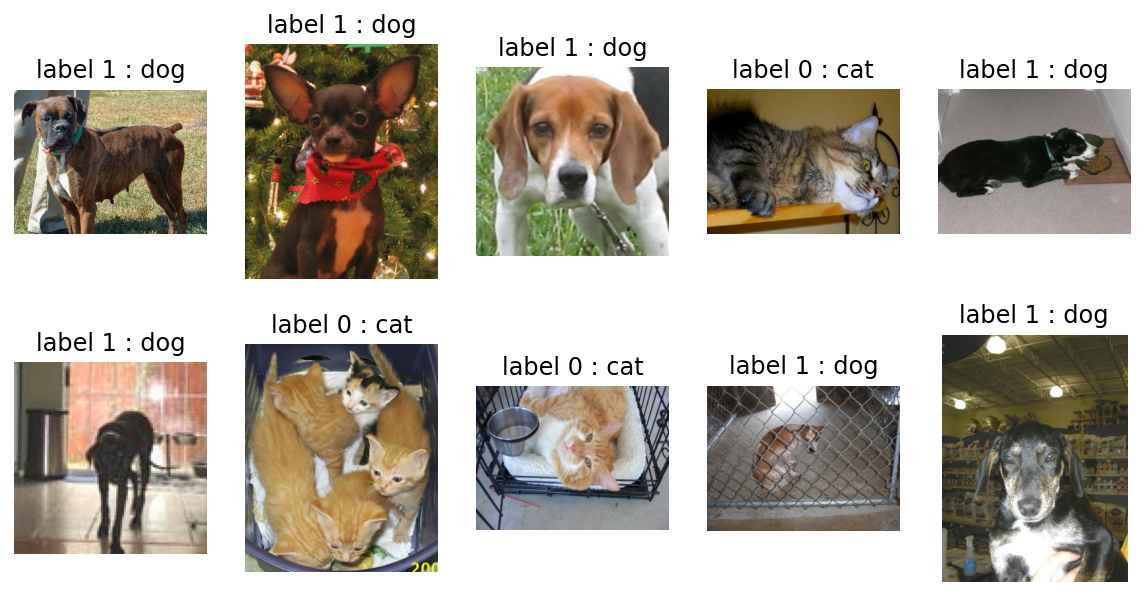

In [31]:
# figure : 차트를 생성
# subplot : 행과 열 지정

plt.figure(figsize=(10,5))

get_label_name = metadata.features['label'].int2str

for idx, (image,label) in enumerate(raw_train.take(10)):
  plt.subplot(2,5,idx+1)
  plt.imshow(image)
  plt.title(f'label {label} : {get_label_name(label)}')
  plt.axis('off')

이미지 리사이징(통일시키기)

In [32]:
# 리사이징 할 사이즈

IMG_SIZE = 160

def format_example(image,label):
  image = tf.cast(image, tf.float32)
  # 픽셀값의 scale 수정 : 0~255 사이의 값들을 그 중간값인 127.5로 나누고 1을 뺐으므로, -1~1 사이의 실수값이 됨
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label


print("슝~")

슝~


여기서 잠깐!! map함수를 알아보자

In [34]:
a = [1.2,2.5,3.7,4.6]
a = list(map(int,a))
print(a)

b = list(map(str, range(10)))
print(b)

[1, 2, 3, 4]
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [35]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


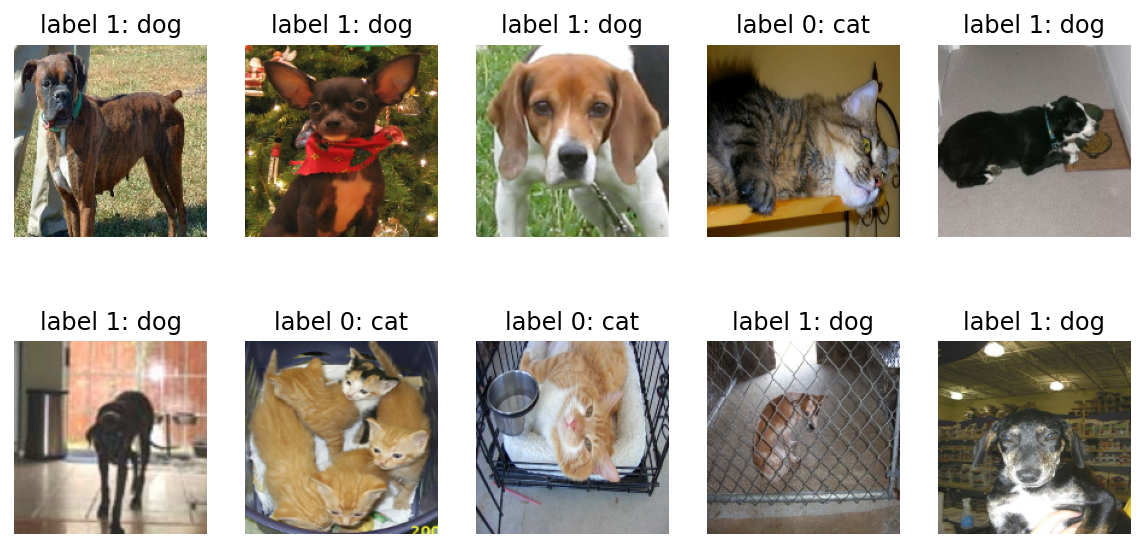

In [36]:
# 이미지 크기가 균일해진다!

plt.figure(figsize=(10,5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
  plt.subplot(2,5,idx+1)
  image = (image+1)/2
  plt.imshow(image)
  plt.title(f'label {label}: {get_label_name(label)}')
  plt.axis('off')

리사이징 전과 후의 시각화의 차이점

matplotlib으로 이미지를 시각화 할 경우에는 모든 픽셀값이 양수여야 하므로, -1\~1 사이의 픽셀값을 1을 더한 후 2로 나눠서 0~1 사이의 값으로 변환하였다.

###**텐서플로우를 활용해 모델 구조 설계**

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

print('슝~')

슝~


In [38]:
model = Sequential([
    Conv2D(filters = 16, kernel_size=3, padding = 'same', activation = 'relu', input_shape=(160,160,3)),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size=3, padding='same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size=3, padding='same', activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation = 'relu'),
    Dense(units=2, activation = 'softmax')
])

In [39]:
model.summary()

# height와 width는 160 → 80 → 40 → 20 으로 점점 작아지고, channel은 16 → 32 → 64까지 커지고 있다.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 64)       0

첫 번째 차원은 데이터의 개수를 나타냅니다. 여기서는 정해지지 않은 수라는 None 기호로 표시되었네요. None은 배치(batch) 사이즈에 따라 모델에 다른 수의 입력이 들어올 수 있음을 나타냅니다.

데이터 하나의 크기는 (height, width, channel)로 3차원이죠. 6개의 레이어를 지나면서 height와 width는 점점 작아지고, channel은 점점 커지다가, flatten 계층을 만나 25,600(20x20x64)이라는 하나의 숫자로, 즉 1차원으로 shape가 줄어듭니다.

앞의 CNN(Convolutional Neural Net)에서 점점 작은 feature map이 출력되다가, Flatten과 Dense 레이어를 거쳐 1차원으로 shape이 줄어드는 네트워크는 CNN을 사용한 딥러닝 모델의 가장 대표적인 형태입니다.

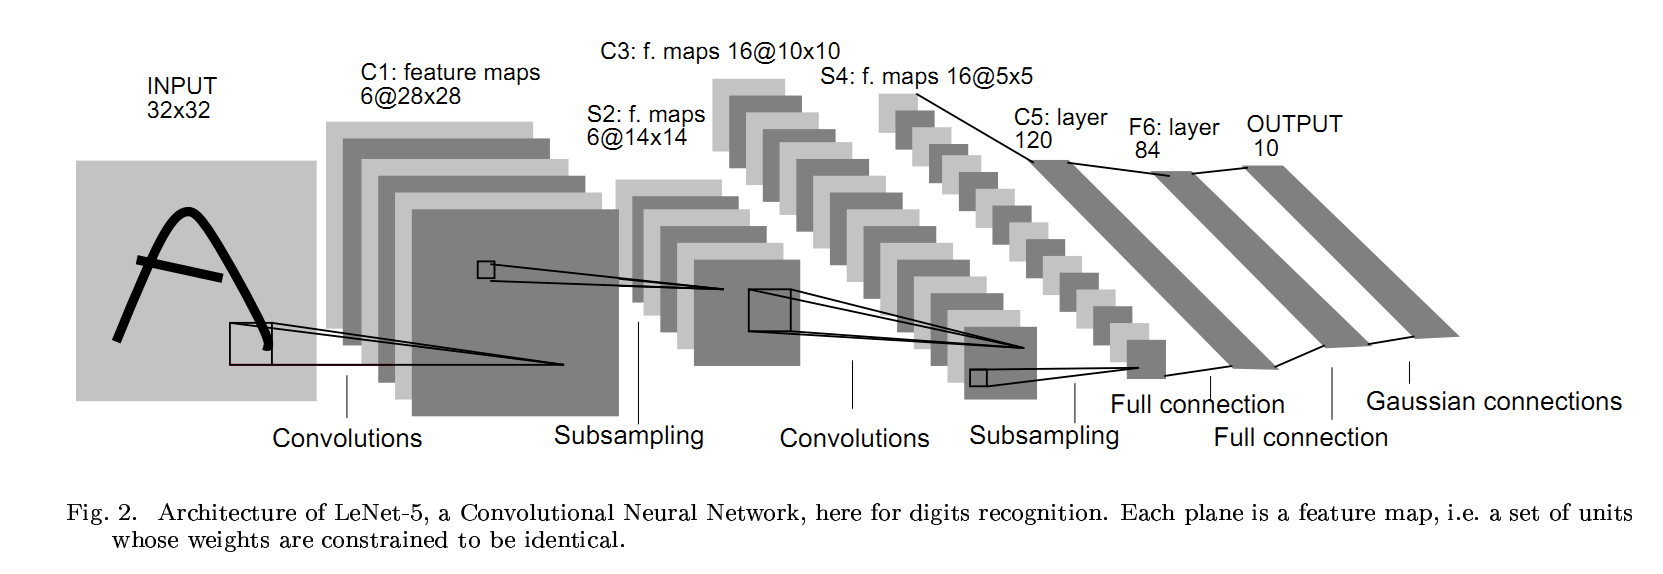


맨 왼쪽처럼 이미지 한 장이 입력되면 그 이미지는 Convolutional(합성곱) 연산을 통해 그 형태가 점점 길쭉해지다가, Flatten 레이어를 만나면 오른쪽처럼 한 줄로 펴집니다. 3차원의 이미지를 1차원 으로 펼치는 거죠.

In [40]:
# 직관적인 fltten의 이해
# flatten : 모든 숫자를 일렬로 펼쳐놓는 것

import numpy as np

image = np.array([[1,2],[3,4]])
print(image.shape)
image

(2, 2)


array([[1, 2],
       [3, 4]])

In [43]:
image.flatten()

array([1, 2, 3, 4])

###**모델 compile완료 후 학습시키기**

- optimizer는 학습을 어떤 방식으로 시킬 것인지 결정합니다. 어떻게 최적화시킬 것인지를 결정하기 때문에 최적화 함수라고 부르기도 합니다.
- loss는 모델이 학습해나가야 하는 방향 을 결정합니다. 이 문제에서는 모델의 출력은 입력받은 이미지가 고양이인지 강아지인지에 대한 확률분포로 두었으므로, 입력 이미지가 고양이(label=0)일 경우 모델의 출력이 [1.0, 0.0]에 가깝도록, 강아지(label=1)일 경우 [0.0, 1.0]에 가까워지도록 하는 방향을 제시합니다.
- metrics는 모델의 성능을 평가하는 척도 입니다. 분류 문제를 풀 때, 성능을 평가할 수 있는 지표는 정확도(accuracy), 정밀도(precision), 재현율(recall) 등이 있습니다. 여기서는 정확도를 사용했습니다.

In [44]:
learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = learning_rate),
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

print("슝~")

슝~


In [45]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
print("슝~")

슝~


BATCH_SIZE에 따라 32개의 데이터를 랜덤으로 뿌려줄 train_batches, validation_batches, test_batches를 만들어 주겠습니다. train_batches는 모델이 끊임없이 학습될 수 있도록 전체 데이터에서 32개를 랜덤으로 뽑아 계속 제공해 줄 것.

In [46]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)
print("슝~")

슝~


In [47]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [50]:
# 초기 모델 성능
# loss : 모델이 얼마나 틀렸는지, 낮을수록 좋음
# accuracy : 몇 퍼센트의 정확도를 보이느냐, 높을수록 좋음

validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 7s 319ms/step - loss: 0.6924 - accuracy: 0.5344
initial loss: 0.69
initial accuracy: 0.53
